In [1]:
import pandas as pd
import numpy as np
import nltk 
import collections
from nltk.tokenize import RegexpTokenizer

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

In [49]:
ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

Now let's get rid of the stop words

In [113]:
from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

We discarded 8545 stop words


In [115]:
print ("Out of {0} words, {1} are unique." 
        " Let's looks at those first.".format(len(word_tokens), 
                                           len(set(word_tokens))))

Out of 10129 words, 2201 are unique. Let's looks at those first.


Workflow:

1. Find the thirty most commonly occuring words.
   Report how often they appear
2. Perform part of speech tagging for the bag of words
   Characterize the distribution of parts of speech

In [116]:
word_tokens[:10]

['people',
 'popcorn',
 'candy',
 'soft',
 'drink',
 'costumes',
 'parading',
 'crowd',
 'people',
 'singing']

In [117]:
counter=collections.Counter(word_tokens)
assert sum(counter.values()) == len(word_tokens)

In [118]:
common_words = counter.most_common(30)

### Plotting word frequency

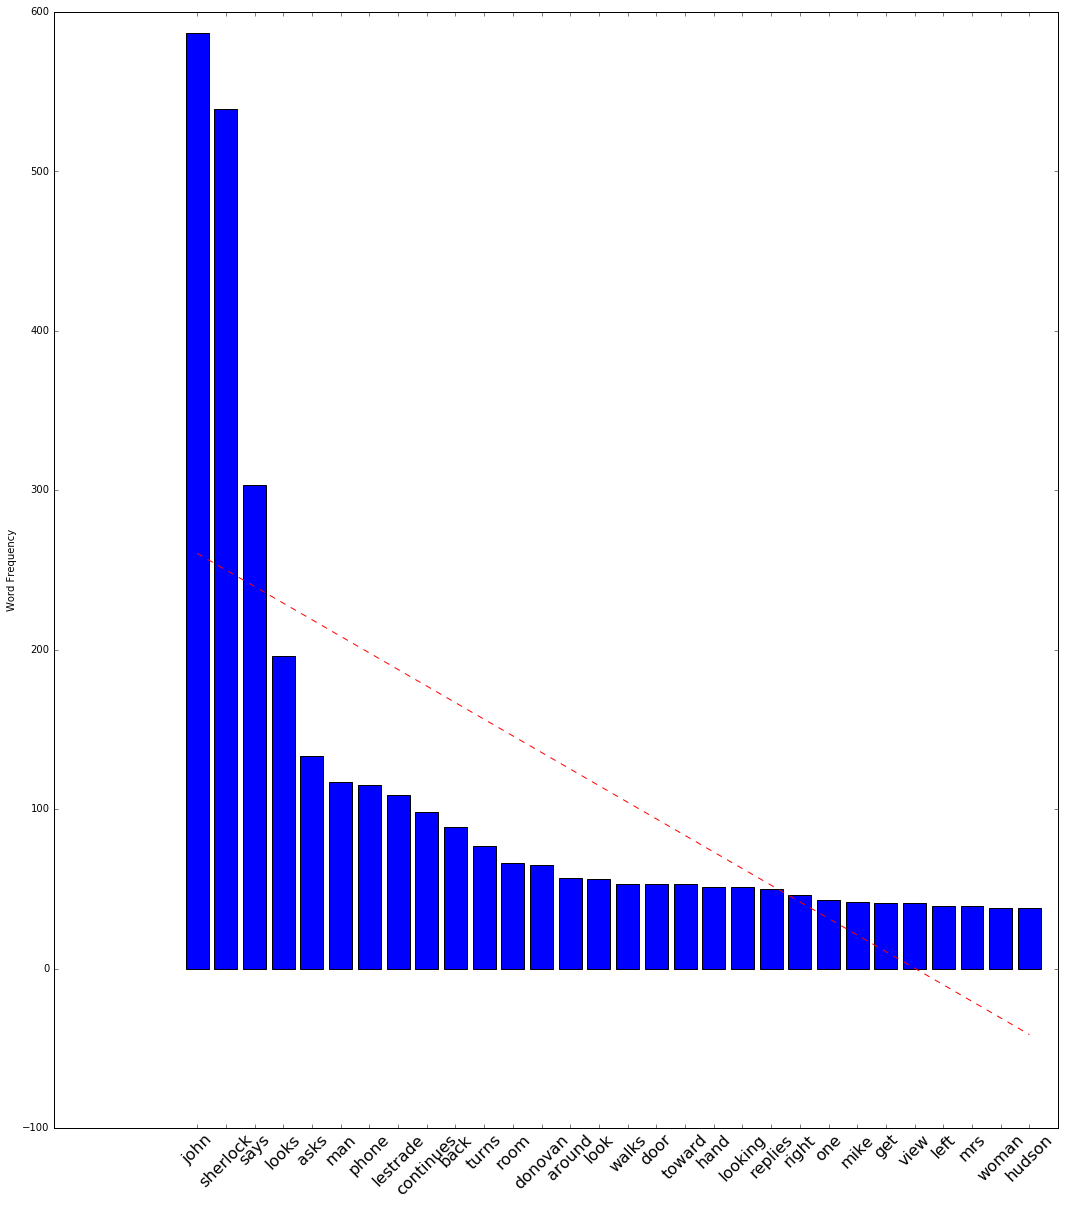

In [130]:
words = zip(*common_words)[0]
freq = zip(*common_words)[1]

x_pos = np.arange(len(words)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, words) 
plt.ylabel('Word Frequency')
plt.show()

In [131]:
# just working with unique words

only_unique_words = list(set(word_tokens))
tagged_words = nltk.pos_tag(only_unique_words)

In [169]:
tagged_words
pos_labels = [pos[1] for pos in tagged_words]
assert len(pos_labels) == len(tagged_words)

pos=collections.Counter(pos_labels)
counter_pos = [(p,pos[p]) for p in pos]

### Plotting part of speech frequency

In [171]:
labels = zip(*counter_pos)[0]
freq = zip(*counter_pos)[1]

In [172]:
x_pos = np.arange(len(labels)) 

slope, intercept = np.polyfit(x_pos, freq, 1)
trendline = intercept + (slope * x_pos)

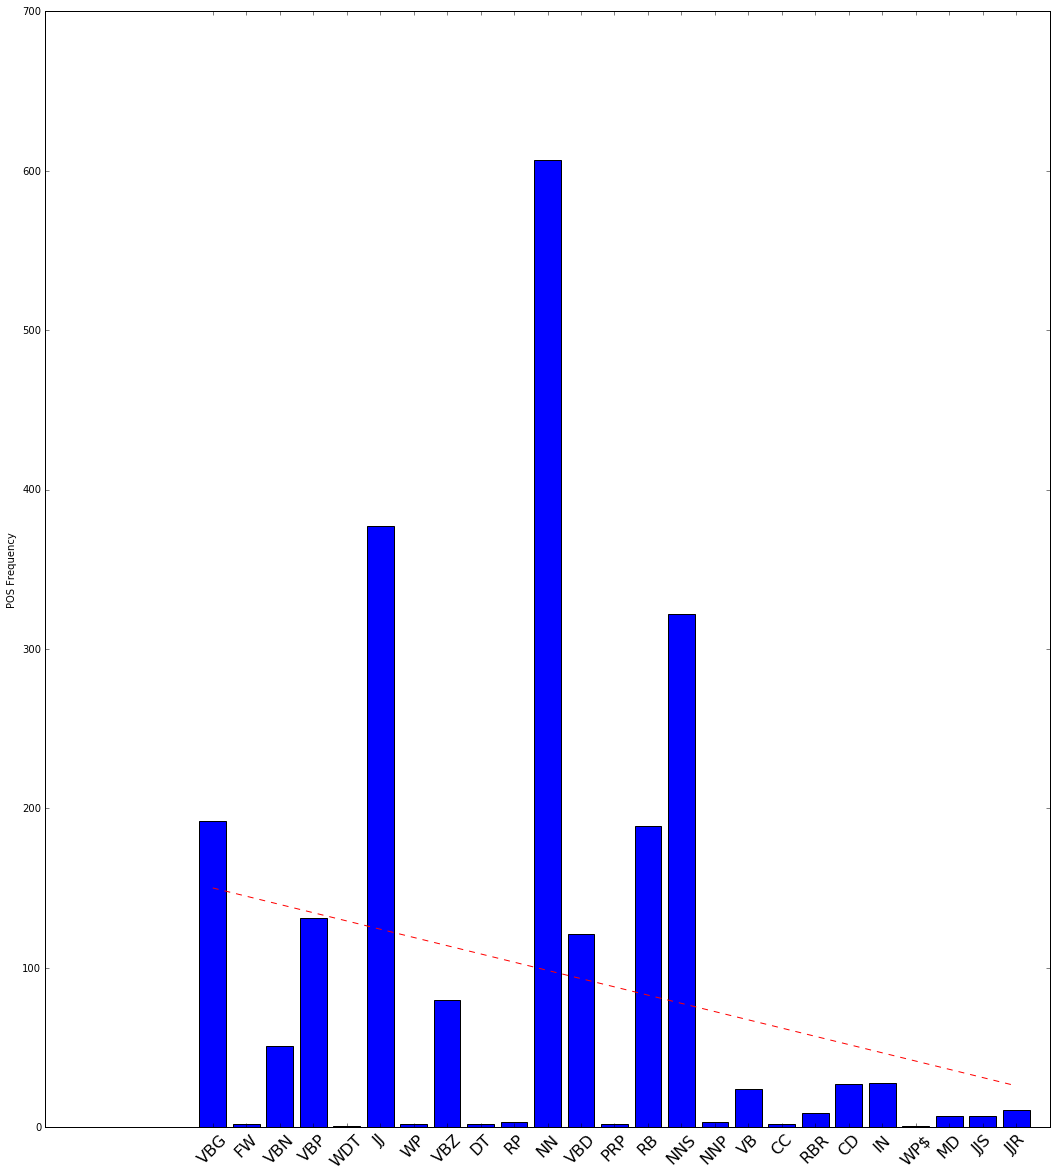

In [174]:
plt.figure(figsize=(18,20))
plt.xticks(fontsize=16, rotation=45)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, freq,align='center')

plt.xticks(x_pos, labels) 
plt.ylabel('POS Frequency')
plt.show()

### Workflow for 08/02:

1. Find vecorized representations of all the words from the annotation
2. Try to use the TR segment onset annotations to create a dataset similar 
   to Alex Huth's formalism 

Basically, try to get as far as before training the regression model

In [59]:
# load trained feature vectors
glove_features = pd.read_table('/Users/vassiki/Desktop/MIND/projects/'
                            'scratch/GloVe-1.2/vectors.txt',header=None)
glove_features.columns = ['vectors']

words_and_vecs = glove_features['vectors'].tolist()
vecs = [[float(v) for v in s.split(" ")[1:]] for s in words_and_vecs]
wl = [s.split(" ")[0] for s in words_and_vecs]
# dimension of each vector is 50 

In [5]:
# put the vocabulary and vectors together in a data frame
lookup = pd.DataFrame({'words': wl, 'vectors': vecs})

In [72]:
# the previous approach takes really long, so we could read all the words
# in the annotation as a bag of words, and then use the feature vectors in the 
# bag of words as a lookup table
ann_file = '/Users/vassiki/Desktop/MIND/projects/sherlock/Sherlock_Segments_1000_NN_2017.xlsx'
ann_df = pd.read_excel(ann_file)

ann_list = ann_df['Scene Details - A Level '].tolist()

ann_words = [a.encode('ascii','ignore') for a in ann_list]

tokenizer = RegexpTokenizer(r'\w+')

tokens_list = [tokenizer.tokenize(a_string) for a_string in ann_words]
tokens = [t for tok in tokens_list for t in tok]

from nltk.corpus import stopwords

stops = list(stopwords.words('english'))
lower_tokens = [t.lower() for t in tokens]
word_tokens = [w for w in lower_tokens if w not in stops]

print "We discarded {0} stop words".format(len(tokens)-len(word_tokens))

# let's get just the unique words

unique_words = list(set(word_tokens))

print "We have {0} unique words from the original {1}".format(len(unique_words),
                                                             len(word_tokens))

We discarded 8545 stop words
We have 2201 unique words from the original 10129


In [89]:
here_counter = 0
not_here_counter = 0
word_vectors = []
for i,widx in enumerate(unique_words):
    if i in range(100,2000,100):
        print ("working on the {0}th word").format(i)
    if widx in lookup['words'].tolist():
        where_idx = lookup.index[lookup['words'] == widx][0]
        word_vectors.append(lookup['vectors'][where_idx])
        #print "{0} is here".format(widx)
        here_counter += 1
    else:
        #print "{0} isn't here".format(widx)
        word_vectors.append(([0]*len(lookup['vectors'][0])))
        not_here_counter += 1   
        
assert len(word_vectors) == len(unique_words)

In [93]:
unique_lookup = pd.DataFrame({'words':unique_words,'vectors':word_vectors})

In [91]:
print "Out of {0} words, we have features for {1} \
and not for {2}".format(len(unique_words),
                        here_counter,not_here_counter)

Out of 2201 words, we have features for 1953 and not for 248


In [ ]:
# create a copy of the dataframe
df = ann_df.copy()

df.Words = ""

for idx in df.shape[0]:
    row_words = df['Scene Details - A Level '][idx]
    



In [124]:
# now that we have features for the unique words, we can go through a lookup
# table created by these words an their features in the annotation data frame
df["Word Vectors"] = ""

for idx in range(df.shape[0]):
    if idx in range(200,1000,200):
        print "Working on word {0}".format(idx)
    word_vec=[]
    tr_words = df["Words"][idx]
    for tr_word in tr_words:
        if tr_word.lower() in unique_lookup['words'].tolist():
            where_idx = unique_lookup.index[unique_lookup['words'] 
                                        == tr_word.lower()][0]
            word_vec.append(unique_lookup['vectors'][where_idx])
        else:
            word_vec.append(([0]*len(lookup['vectors'][0])))
    df.at[idx,"Word Vectors"] = word_vec


Working on word 200
Working on word 400
Working on word 600
Working on word 800


In [ ]:
# more ideas: feature vectors for only dialog in a given segment,
#             compare with feature vectors all description in each segment  

In [ ]:
# add them up